# UCI HAR - classification
- https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

#### 데이터 종류
- 561개 특성으로 전처리된 메인 데이터셋(X_train, X_test)
- Inertial Signals 데이터셋: 원시 센서 값(raw signal)

#### Inertial Signals 데이터 구조
- 각 파일은 행 = 샘플(segment), 열 = 시계열 프레임을 의미
- 각 샘플은 2.56초 길이 (샘플링 주파수 50Hz, 128 타임스텝 → 128 / 50 = 2.56초)
- 이미 샘플링이 되어 있으므로(7352개의 샘플) split_sequence() 사용하지 않아도 됨
- 한 행이 (128,) 길이의 시계열 벡터
- 세 축(X, Y, Z)와 센서 종류(acc, gyro)로 분리되어 있음

#### 센서 및 값의 의미
- Total acceleration (total_acc): 스마트폰 가속도계로 측정한 총 가속도 (중력 + 신체 움직임 포함)
- Body acceleration (body_acc): 총 가속도에서 중력 성분을 제거한 값 (실제 동작 가속도)
- Gyroscope (body_gyro): 각속도(회전 속도), 단위는 rad/sec, 스마트폰의 자이로스코프 센서 값

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

In [ ]:
TRAIN = "train/"
TEST = "test/"

DATASET_PATH = "/content/drive/MyDrive/AI_data/UCI HAR Dataset/"

# Load "X"
def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        series_list = []  # 한 센서축 데이터 전체 저장

        with open(signal_type_path, 'r') as file:
            for row in file:
                row_clean = row.replace('  ', ' ') # 공백 2개를 1개로
                row_clean = row_clean.strip() # 양쪽 공백 제거
                serie = row_clean.split(' ') # 공백 기준 split
                serie_array = np.array(serie, dtype=np.float32) # float32 numpy 배열로 변환
                series_list.append(serie_array) # 시퀀스 추가

        # 하나의 센서축 데이터 추가 (feature)
        X_signals.append(series_list)

    # shape: (특성 수, 샘플 수, 타임스텝 수)
    X_signals = np.array(X_signals)
    # shape 변환 → (샘플 수, 타임스텝 수, 특성 수)
    return np.transpose(X_signals, (1, 2, 0))


X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt"
    for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt"
    for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("첫 번째 샘플 데이터:\n", X_train[0])


X_train shape: (7352, 128, 9)
X_test shape: (2947, 128, 9)
첫 번째 샘플 데이터:
 [[ 1.808515e-04  1.076681e-02  5.556068e-02 ...  1.012817e+00
  -1.232167e-01  1.029341e-01]
 [ 1.013856e-02  6.579480e-03  5.512483e-02 ...  1.022833e+00
  -1.268756e-01  1.056872e-01]
 [ 9.275574e-03  8.928878e-03  4.840473e-02 ...  1.022028e+00
  -1.240037e-01  1.021025e-01]
 ...
 [-1.147484e-03  1.714439e-04  2.647864e-03 ...  1.018445e+00
  -1.240696e-01  1.003852e-01]
 [-2.222655e-04  1.574181e-03  2.381057e-03 ...  1.019372e+00
  -1.227451e-01  9.987355e-02]
 [ 1.575500e-03  3.070189e-03 -2.269757e-03 ...  1.021171e+00
  -1.213260e-01  9.498741e-02]]


In [ ]:
# Load "y"

def load_y(y_path):
    with open(y_path, 'r') as file:
        labels = [int(line.strip()) for line in file]
    # 라벨을 0부터 시작하도록 -1 (원래 라벨이 1부터 시)
    return np.array(labels, dtype=np.int32) - 1


y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(y_train[:5])

y_train shape: (7352,)
y_test shape: (2947,)
[4 4 4 4 4]


In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = 6

model = Sequential([
    Input(shape=input_shape),

    Conv1D(64, 5, padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv1D(128, 3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(2),

    Conv1D(256, 3, padding='same'),
    BatchNormalization(),
    ReLU(),

    GlobalAveragePooling1D(),

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 128, 64)        │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 128, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 64, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,670 (631.52 KB)

 Trainable params: 160,774 (628.02 KB)

 Non-trainable params: 896 (3.50 KB)

None


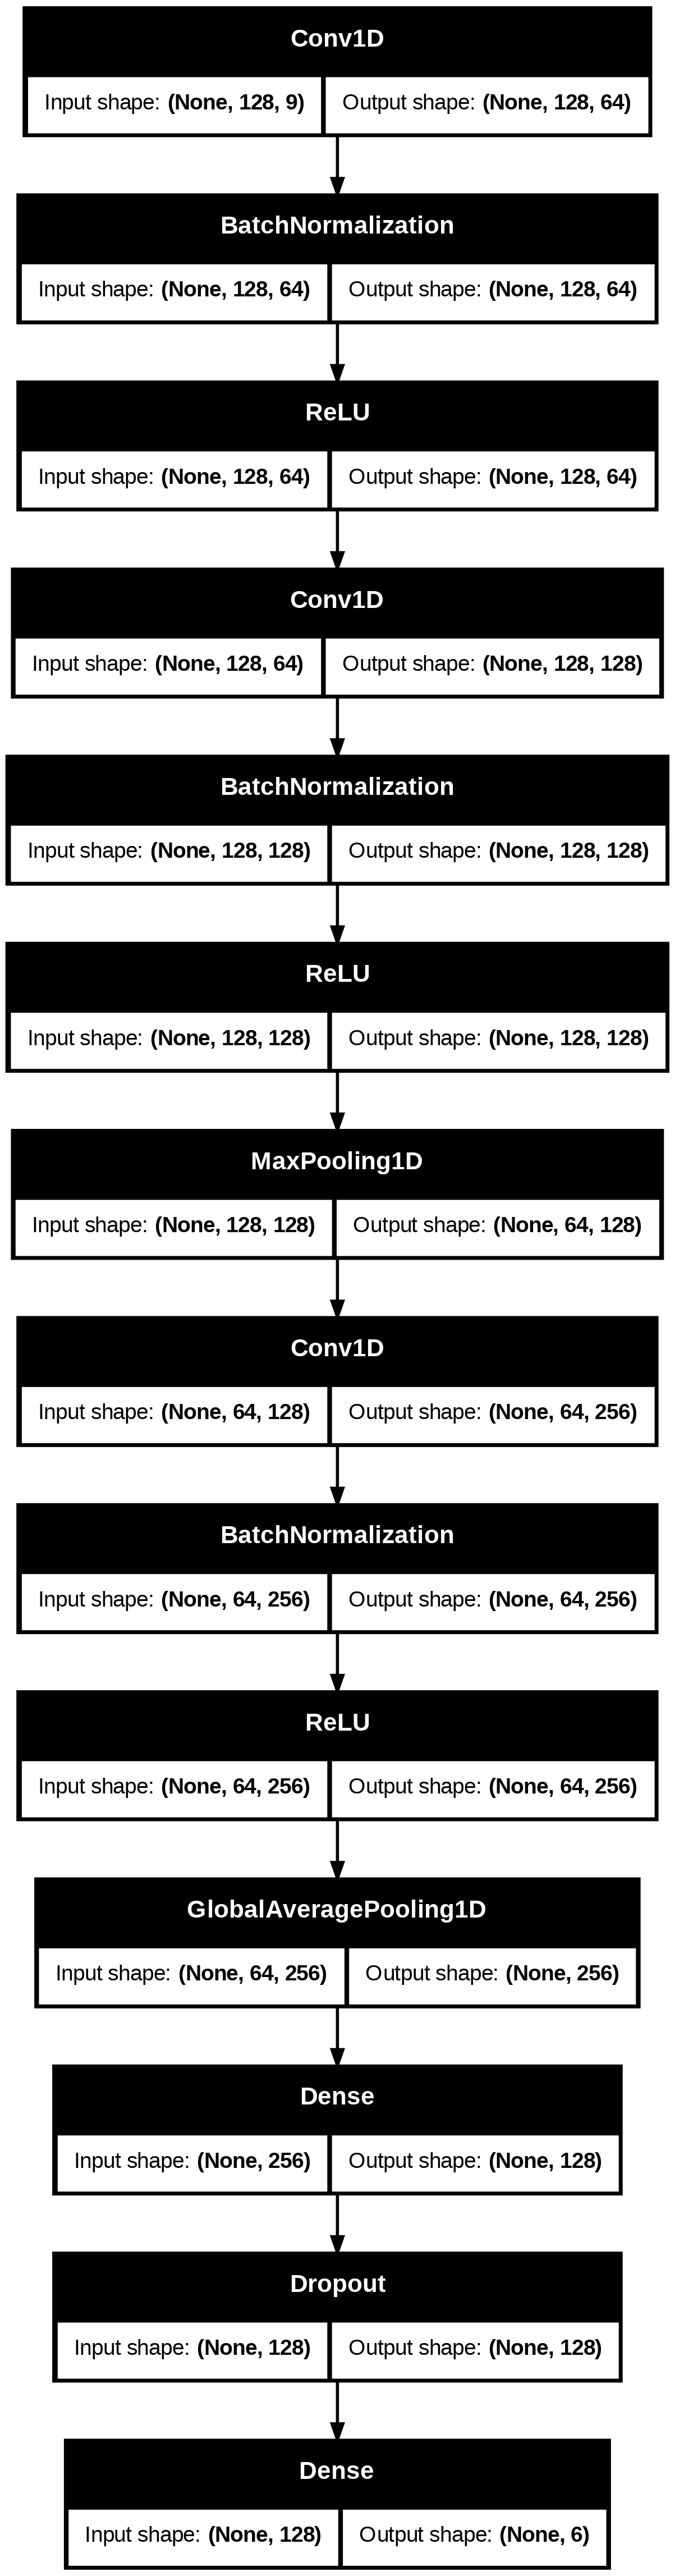

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "UCI_HAR_CNN_best.h5",
                save_best_only=True,
                monitor="sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=64,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.5574 - sparse_categorical_accuracy: 0.7820
Epoch 1: sparse_categorical_accuracy improved from -inf to 0.88097, saving model to UCI_HAR_CNN_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - loss: 0.5547 - sparse_categorical_accuracy: 0.7831 - val_loss: 2.7839 - val_sparse_categorical_accuracy: 0.2903
Epoch 2/100
81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1109 - sparse_categorical_accuracy: 0.9544
Epoch 2: sparse_categorical_accuracy improved from 0.88097 to 0.94865, saving model to UCI_HAR_CNN_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1120 - sparse_categorical_accuracy: 0.9536 - val_loss: 2.5935 - val_sparse_categorical_accuracy: 0.3243
Epoch 3/100
86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1175 - sparse_categorical_accuracy: 0.9476
Epoch 3: sparse_categorical_accuracy improved from 0.94865 to 0.95154, saving model to UCI_HAR_CNN_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1168 - sparse_categorical_accuracy: 0.9479 - val_loss: 0.9842 - val_sparse_categorical_accuracy: 0.6431
Epoch 4/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1139 - sparse_categorical_accuracy: 0.9539 
Epoch 4: sparse_categorical_accuracy improved from 0.95154 to 0.95443, saving model to UCI_HAR_CNN_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1134 - sparse_categorical_accuracy: 0.9539 - val_loss: 0.3206 - val_sparse_categorical_accuracy: 0.8960
Epoch 5/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1000 - sparse_categorical_accuracy: 0.9511
Epoch 5: sparse_categorical_accuracy did not improve from 0.95443
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0999 - sparse_categorical_accuracy: 0.9511 - val_loss: 0.2873 - val_sparse_categorical_accuracy: 0.9089
Epoch 6/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0869 - sparse_categorical_accuracy: 0.9590
Epoch 6: sparse_categorical_accuracy improved from 0.95443 to 0.95664, saving model to UCI_HAR_CNN_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0870 - sparse_categorical_accuracy: 0.9589 - val_loss: 0.2680 - val_sparse_categorical_accuracy: 0.9089
Epoch 7/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0943 - sparse_categorical_accuracy: 0.9538
Epoch 7: sparse_categorical_accuracy improved from 0.95664 to 0.95766, saving model to UCI_HAR_CNN_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0944 - sparse_categorical_accuracy: 0.9539 - val_loss: 0.6461 - val_sparse_categorical_accuracy: 0.8498
Epoch 8/100
87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1116 - sparse_categorical_accuracy: 0.9496
Epoch 8: sparse_categorical_accuracy did not improve from 0.95766
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1108 - sparse_categorical_accuracy: 0.9499 - val_loss: 0.3277 - val_sparse_categorical_accuracy: 0.8899
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0941 - sparse_categorical_accuracy: 0.9587
Epoch 9: sparse_categorical_accuracy improved from 0.95766 to 0.95800, saving model to UCI_HAR_CNN_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0941 - sparse_categorical_accuracy: 0.9587 - val_loss: 0.3549 - val_sparse_categorical_accuracy: 0.9130
Epoch 10/100
80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0832 - sparse_categorical_accuracy: 0.9593
Epoch 10: sparse_categorical_accuracy improved from 0.95800 to 0.95817, saving model to UCI_HAR_CNN_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0834 - sparse_categorical_accuracy: 0.9592 - val_loss: 0.3826 - val_sparse_categorical_accuracy: 0.9184
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0818 - sparse_categorical_accuracy: 0.9646
Epoch 11: sparse_categorical_accuracy improved from 0.95817 to 0.95936, saving model to UCI_HAR_CNN_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0819 - sparse_categorical_accuracy: 0.9645 - val_loss: 0.2988 - val_sparse_categorical_accuracy: 0.9273
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0860 - sparse_categorical_accuracy: 0.9626
Epoch 12: sparse_categorical_accuracy did not improve from 0.95936
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0860 - sparse_categorical_accuracy: 0.9626 - val_loss: 0.4106 - val_sparse_categorical_accuracy: 0.9171
Epoch 13/100
82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0755 - sparse_categorical_accuracy: 0.9664
Epoch 13: sparse_categorical_accuracy improved from 0.95936 to 0.96225, saving model to UCI_HAR_CNN_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0755 - sparse_categorical_accuracy: 0.9660 - val_loss: 0.3622 - val_sparse_categorical_accuracy: 0.9307
Epoch 14/100
83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0844 - sparse_categorical_accuracy: 0.9587
Epoch 14: sparse_categorical_accuracy did not improve from 0.96225
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0848 - sparse_categorical_accuracy: 0.9587 - val_loss: 0.3820 - val_sparse_categorical_accuracy: 0.9375
Epoch 15/100
83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0730 - sparse_categorical_accuracy: 0.9657
Epoch 15: sparse_categorical_accuracy improved from 0.96225 to 0.96412, saving model to UCI_HAR_CNN_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0738 - sparse_categorical_accuracy: 0.9656 - val_loss: 0.3544 - val_sparse_categorical_accuracy: 0.9137
Epoch 16/100
85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0790 - sparse_categorical_accuracy: 0.9635
Epoch 16: sparse_categorical_accuracy did not improve from 0.96412
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0799 - sparse_categorical_accuracy: 0.9630 - val_loss: 0.3368 - val_sparse_categorical_accuracy: 0.9035
Epoch 17/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0775 - sparse_categorical_accuracy: 0.9653
Epoch 17: sparse_categorical_accuracy did not improve from 0.96412
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0776 - sparse_categorical_accuracy: 0.9652 - val_loss: 0.4337 - val_sparse_categorical_accuracy: 0.9388
Epoch 18/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0778 - sparse_categorical_accuracy: 0.9625
Epoch 18: sparse_categorical_accuracy did not improve from 0.96412
92/92 ━━━━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0741 - sparse_categorical_accuracy: 0.9621 - val_loss: 0.2763 - val_sparse_categorical_accuracy: 0.9191
Epoch 20/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0743 - sparse_categorical_accuracy: 0.9647
Epoch 20: sparse_categorical_accuracy did not improve from 0.96480
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0743 - sparse_categorical_accuracy: 0.9647 - val_loss: 0.3693 - val_sparse_categorical_accuracy: 0.9245
Epoch 21/100
84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0794 - sparse_categorical_accuracy: 0.9631
Epoch 21: sparse_categorical_accuracy did not improve from 0.96480
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0799 - sparse_categorical_accuracy: 0.9629 - val_loss: 0.3536 - val_sparse_categorical_accuracy: 0.8926
Epoch 22/100
83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0733 - sparse_categorical_accuracy: 0.9646
Epoch 22: sparse_categorical_accuracy did not improve from 0.96480
92/92 ━━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0719 - sparse_categorical_accuracy: 0.9668 - val_loss: 0.3607 - val_sparse_categorical_accuracy: 0.9300
Epoch 26/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0781 - sparse_categorical_accuracy: 0.9634
Epoch 26: sparse_categorical_accuracy did not improve from 0.96514
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0779 - sparse_categorical_accuracy: 0.9634 - val_loss: 0.3625 - val_sparse_categorical_accuracy: 0.9429
Epoch 27/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0769 - sparse_categorical_accuracy: 0.9664
Epoch 27: sparse_categorical_accuracy improved from 0.96514 to 0.96582, saving model to UCI_HAR_CNN_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0770 - sparse_categorical_accuracy: 0.9664 - val_loss: 0.3181 - val_sparse_categorical_accuracy: 0.9266
Epoch 28/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0813 - sparse_categorical_accuracy: 0.9649
Epoch 28: sparse_categorical_accuracy did not improve from 0.96582
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0813 - sparse_categorical_accuracy: 0.9649 - val_loss: 0.3475 - val_sparse_categorical_accuracy: 0.9245
Epoch 29/100
85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0655 - sparse_categorical_accuracy: 0.9723
Epoch 29: sparse_categorical_accuracy did not improve from 0.96582
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0665 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.3084 - val_sparse_categorical_accuracy: 0.9109
Epoch 30/100
84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0678 - sparse_categorical_accuracy: 0.9700
Epoch 30: sparse_categorical_accuracy improved from 0.96582 to 0.96718, saving model to UCI_

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0681 - sparse_categorical_accuracy: 0.9697 - val_loss: 0.3358 - val_sparse_categorical_accuracy: 0.9137
Epoch 31/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0671 - sparse_categorical_accuracy: 0.9668
Epoch 31: sparse_categorical_accuracy improved from 0.96718 to 0.96854, saving model to UCI_HAR_CNN_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0671 - sparse_categorical_accuracy: 0.9669 - val_loss: 0.3846 - val_sparse_categorical_accuracy: 0.9130
Epoch 32/100
86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0713 - sparse_categorical_accuracy: 0.9654
Epoch 32: sparse_categorical_accuracy did not improve from 0.96854
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0711 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.3752 - val_sparse_categorical_accuracy: 0.9436
Epoch 33/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0689 - sparse_categorical_accuracy: 0.9660
Epoch 33: sparse_categorical_accuracy did not improve from 0.96854
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0690 - sparse_categorical_accuracy: 0.9661 - val_loss: 0.4193 - val_sparse_categorical_accuracy: 0.9116
Epoch 34/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0686 - sparse_categorical_accuracy: 0.9686
Epoch 34: sparse_categorical_accuracy improved from 0.96854 to 0.96990, saving model to UCI_

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0686 - sparse_categorical_accuracy: 0.9686 - val_loss: 0.3808 - val_sparse_categorical_accuracy: 0.9062
Epoch 35/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0653 - sparse_categorical_accuracy: 0.9709
Epoch 35: sparse_categorical_accuracy improved from 0.96990 to 0.97007, saving model to UCI_HAR_CNN_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0654 - sparse_categorical_accuracy: 0.9709 - val_loss: 0.3901 - val_sparse_categorical_accuracy: 0.9415
Epoch 36/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0621 - sparse_categorical_accuracy: 0.9725 
Epoch 36: sparse_categorical_accuracy improved from 0.97007 to 0.97109, saving model to UCI_HAR_CNN_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0621 - sparse_categorical_accuracy: 0.9724 - val_loss: 0.4025 - val_sparse_categorical_accuracy: 0.9293
Epoch 37/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0664 - sparse_categorical_accuracy: 0.9669
Epoch 37: sparse_categorical_accuracy did not improve from 0.97109
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0663 - sparse_categorical_accuracy: 0.9670 - val_loss: 0.3675 - val_sparse_categorical_accuracy: 0.9341
Epoch 38/100
86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0583 - sparse_categorical_accuracy: 0.9736
Epoch 38: sparse_categorical_accuracy did not improve from 0.97109
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0587 - sparse_categorical_accuracy: 0.9733 - val_loss: 0.4589 - val_sparse_categorical_accuracy: 0.9341
Epoch 39/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0760 - sparse_categorical_accuracy: 0.9650
Epoch 39: sparse_categorical_accuracy did not improve from 0.97109
92/92 ━━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0667 - sparse_categorical_accuracy: 0.9732 - val_loss: 0.4213 - val_sparse_categorical_accuracy: 0.9307
Epoch 50/100
83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0582 - sparse_categorical_accuracy: 0.9751
Epoch 50: sparse_categorical_accuracy did not improve from 0.97228
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0590 - sparse_categorical_accuracy: 0.9747 - val_loss: 0.2511 - val_sparse_categorical_accuracy: 0.9150
Epoch 51/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0614 - sparse_categorical_accuracy: 0.9701
Epoch 51: sparse_categorical_accuracy did not improve from 0.97228
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0614 - sparse_categorical_accuracy: 0.9701 - val_loss: 0.3844 - val_sparse_categorical_accuracy: 0.9361
Epoch 52/100
83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0604 - sparse_categorical_accuracy: 0.9708
Epoch 52: sparse_categorical_accuracy did not improve from 0.97228
92/92 ━━━━━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0540 - sparse_categorical_accuracy: 0.9754 - val_loss: 0.2563 - val_sparse_categorical_accuracy: 0.9116
Epoch 57/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0616 - sparse_categorical_accuracy: 0.9734
Epoch 57: sparse_categorical_accuracy did not improve from 0.97347
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0616 - sparse_categorical_accuracy: 0.9734 - val_loss: 0.4118 - val_sparse_categorical_accuracy: 0.9470
Epoch 58/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0601 - sparse_categorical_accuracy: 0.9727
Epoch 58: sparse_categorical_accuracy did not improve from 0.97347
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0601 - sparse_categorical_accuracy: 0.9727 - val_loss: 0.4310 - val_sparse_categorical_accuracy: 0.9388
Epoch 59/100
79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0631 - sparse_categorical_accuracy: 0.9679
Epoch 59: sparse_categorical_accuracy did not improve from 0.97347
92/92 ━━━━━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0557 - sparse_categorical_accuracy: 0.9751 - val_loss: 0.3754 - val_sparse_categorical_accuracy: 0.9320
Epoch 73/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0696 - sparse_categorical_accuracy: 0.9716
Epoch 73: sparse_categorical_accuracy did not improve from 0.97398
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0694 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.3063 - val_sparse_categorical_accuracy: 0.9191
Epoch 74/100
80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0570 - sparse_categorical_accuracy: 0.9756
Epoch 74: sparse_categorical_accuracy improved from 0.97398 to 0.97585, saving model to UCI_HAR_CNN_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0569 - sparse_categorical_accuracy: 0.9756 - val_loss: 0.3817 - val_sparse_categorical_accuracy: 0.9443
Epoch 75/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0696 - sparse_categorical_accuracy: 0.9713
Epoch 75: sparse_categorical_accuracy did not improve from 0.97585
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0695 - sparse_categorical_accuracy: 0.9713 - val_loss: 0.4117 - val_sparse_categorical_accuracy: 0.9327
Epoch 76/100
80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0571 - sparse_categorical_accuracy: 0.9707
Epoch 76: sparse_categorical_accuracy did not improve from 0.97585
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0564 - sparse_categorical_accuracy: 0.9714 - val_loss: 0.4056 - val_sparse_categorical_accuracy: 0.9300
Epoch 77/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0691 - sparse_categorical_accuracy: 0.9719
Epoch 77: sparse_categorical_accuracy did not improve from 0.97585
92/92 ━━━━━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0529 - sparse_categorical_accuracy: 0.9751 - val_loss: 0.4270 - val_sparse_categorical_accuracy: 0.9456
Epoch 84/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0557 - sparse_categorical_accuracy: 0.9742
Epoch 84: sparse_categorical_accuracy did not improve from 0.97653
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0559 - sparse_categorical_accuracy: 0.9741 - val_loss: 0.3077 - val_sparse_categorical_accuracy: 0.9415
Epoch 85/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0629 - sparse_categorical_accuracy: 0.9711
Epoch 85: sparse_categorical_accuracy did not improve from 0.97653
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0628 - sparse_categorical_accuracy: 0.9711 - val_loss: 0.2967 - val_sparse_categorical_accuracy: 0.9436
Epoch 86/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0531 - sparse_categorical_accuracy: 0.9748
Epoch 86: sparse_categorical_accuracy did not improve from 0.97653
92/92 ━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0436 - sparse_categorical_accuracy: 0.9797 - val_loss: 0.4696 - val_sparse_categorical_accuracy: 0.9375
Epoch 91/100
81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0527 - sparse_categorical_accuracy: 0.9772
Epoch 91: sparse_categorical_accuracy did not improve from 0.97841
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0526 - sparse_categorical_accuracy: 0.9769 - val_loss: 0.2840 - val_sparse_categorical_accuracy: 0.9375
Epoch 92/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0516 - sparse_categorical_accuracy: 0.9751
Epoch 92: sparse_categorical_accuracy did not improve from 0.97841
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0515 - sparse_categorical_accuracy: 0.9751 - val_loss: 0.2726 - val_sparse_categorical_accuracy: 0.9409
Epoch 93/100
80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0456 - sparse_categorical_accuracy: 0.9748
Epoch 93: sparse_categorical_accuracy did not improve from 0.97841
92/92 ━━━━━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0445 - sparse_categorical_accuracy: 0.9813 - val_loss: 0.4967 - val_sparse_categorical_accuracy: 0.9470
Epoch 100/100
82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0496 - sparse_categorical_accuracy: 0.9744
Epoch 100: sparse_categorical_accuracy did not improve from 0.97994
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0500 - sparse_categorical_accuracy: 0.9742 - val_loss: 0.3743 - val_sparse_categorical_accuracy: 0.9368
Restoring model weights from the end of the best epoch: 99.


In [ ]:
# 모델 평가
model = tf.keras.models.load_model("UCI_HAR_CNN_best.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 97.33%
Training loss: 0.1333
Test accuracy: 93.38%
Test loss: 0.5580


model.predict
- 각 시퀀스 샘플마다, 모든 클래스에 대한 예측 확률 벡터
- y_pred_proba.shape -> (샘플 수, 클래스 수)

np.argmax
- 최대 값의 인덱스를 선택 = 라벨

In [ ]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9496    0.9741       496
           1     0.9675    0.9469    0.9571       471
           2     0.8936    1.0000    0.9438       420
           3     0.8745    0.8228    0.8478       491
           4     0.8697    0.8910    0.8802       532
           5     0.9981    1.0000    0.9991       537

    accuracy                         0.9338      2947
   macro avg     0.9339    0.9351    0.9337      2947
weighted avg     0.9349    0.9338    0.9336      2947



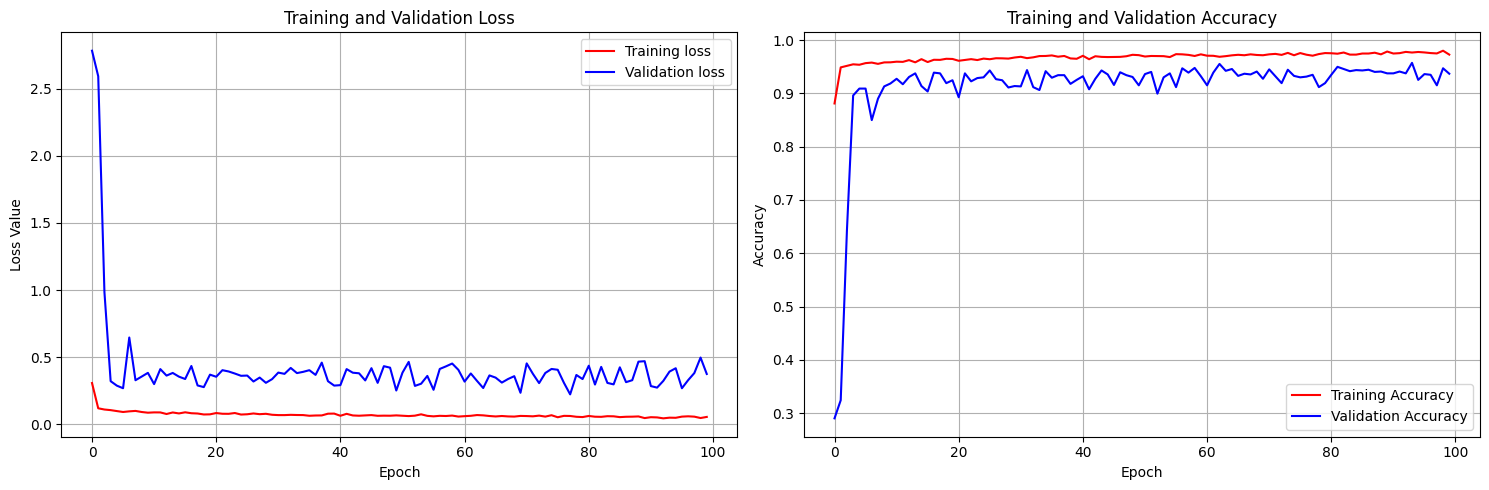

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

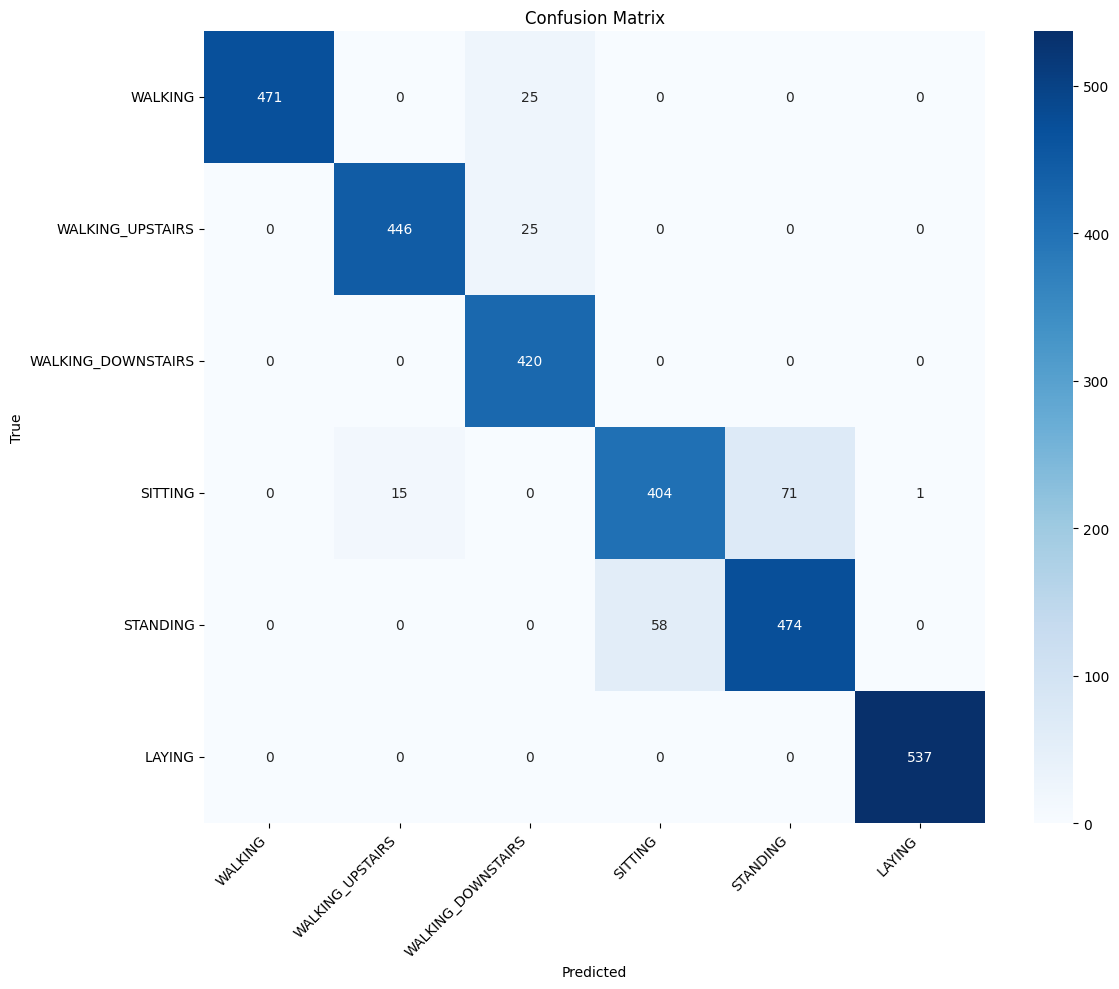

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()